# Importing libraries

In [1]:
import torch
import torch.nn as nn
from huggingface_hub import hf_hub_download
import os
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# Defining Models

In [2]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3, 3), padding="same")
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding="same")
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), padding=0)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding="same")
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2), padding=0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        return x


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=2, padding=1, output_padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=2, padding=1, output_padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=2, padding=1, output_padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(32, 3, kernel_size=(3, 3), padding="same")
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.deconv1(x)
        x = self.relu1(x)
        x = self.deconv2(x)
        x = self.relu2(x)
        x = self.deconv3(x)
        x = self.relu3(x)
        x = self.conv(x)
        x = self.sig(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [3]:
class Noise_Estimation(nn.Module):
    def __init__(self):
        super(Noise_Estimation, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, (3, 3), padding="same")
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 32, (3, 3), padding="same")
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(32, 32, (3, 3), padding="same")
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(32, 32, (3, 3), padding="same")
        self.relu4 = nn.ReLU()
        self.conv5 = nn.Conv2d(32, 3, (3, 3), padding="same")
        self.relu5 = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.conv5(x)
        x = self.relu5(x)

        return x


class Denoising(nn.Module):
    def __init__(self):
        super(Denoising, self).__init__()

        self.conv1 = nn.Conv2d(6, 64, (3, 3), padding="same")
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 64, (3, 3), padding="same")
        self.relu2 = nn.ReLU()

        self.pool1 = nn.AvgPool2d((2, 2), padding=0)

        self.conv3 = nn.Conv2d(64, 128, (3, 3), padding="same")
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(128, 128, (3, 3), padding="same")
        self.relu4 = nn.ReLU()
        self.conv5 = nn.Conv2d(128, 128, (3, 3), padding="same")
        self.relu5 = nn.ReLU()

        self.pool2 = nn.AvgPool2d((2, 2), padding=0)

        self.conv6 = nn.Conv2d(128, 256, (3, 3), padding="same")
        self.relu6 = nn.ReLU()
        self.conv7 = nn.Conv2d(256, 256, (3, 3), padding="same")
        self.relu7 = nn.ReLU()
        self.conv8 = nn.Conv2d(256, 256, (3, 3), padding="same")
        self.relu8 = nn.ReLU()
        self.conv9 = nn.Conv2d(256, 256, (3, 3), padding="same")
        self.relu9 = nn.ReLU()
        self.conv10 = nn.Conv2d(256, 256, (3, 3), padding="same")
        self.relu10 = nn.ReLU()
        self.conv11 = nn.Conv2d(256, 256, (3, 3), padding="same")
        self.relu11 = nn.ReLU()

        self.convT1 = nn.ConvTranspose2d(256, 128, (2, 2), stride=2)
        self.reluT1 = nn.ReLU()

        self.conv12 = nn.Conv2d(128, 128, (3, 3), padding="same")
        self.relu12 = nn.ReLU()
        self.conv13 = nn.Conv2d(128, 128, (3, 3), padding="same")
        self.relu13 = nn.ReLU()
        self.conv14 = nn.Conv2d(128, 128, (3, 3), padding="same")
        self.relu14 = nn.ReLU()

        self.convT2 = nn.ConvTranspose2d(128, 64, (2, 2), stride=2)
        self.reluT2 = nn.ReLU()

        self.conv15 = nn.Conv2d(64, 64, (3, 3), padding="same")
        self.relu15 = nn.ReLU()
        self.conv16 = nn.Conv2d(64, 64, (3, 3), padding="same")
        self.relu16 = nn.ReLU()
        self.conv17 = nn.Conv2d(64, 3, (3, 3), padding="same")
        self.relu17 = nn.ReLU()

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.relu1(x1)
        x3 = self.conv2(x2)
        x4 = self.relu2(x3)
        x5 = self.pool1(x4)
        x6 = self.conv3(x5)
        x7 = self.relu3(x6)
        x8 = self.conv4(x7)
        x9 = self.relu4(x8)
        x10 = self.conv5(x9)
        x11 = self.relu5(x10)
        x12 = self.pool2(x11)
        x13 = self.conv6(x12)
        x14 = self.relu6(x13)
        x15 = self.conv7(x14)
        x16 = self.relu7(x15)
        x17 = self.conv8(x16)
        x18 = self.relu8(x17)
        x19 = self.conv9(x18)
        x20 = self.relu9(x19)
        x21 = self.conv10(x20)
        x22 = self.relu10(x21)
        x23 = self.conv11(x22)
        x24 = self.relu11(x23)
        x25 = self.convT1(x24)
        x26 = self.reluT1(x25)
        x27 = x26 + x11
        x28 = self.conv12(x27)
        x29 = self.relu12(x28)
        x30 = self.conv13(x29)
        x31 = self.relu13(x30)
        x32 = self.conv14(x31)
        x33 = self.relu14(x32)
        x34 = self.convT2(x33)
        x35 = self.reluT2(x34)
        x36 = x35 + x4
        x37 = self.conv15(x36)
        x38 = self.relu15(x37)
        x39 = self.conv16(x38)
        x40 = self.relu16(x39)
        x41 = self.conv17(x40)
        x42 = self.relu17(x41)

        return x42


class CBDNet(nn.Module):
    def __init__(self):
        super(CBDNet, self).__init__()

        self.noise_estimation = Noise_Estimation()
        self.denoising = Denoising()

    def forward(self, input):
        x = self.noise_estimation(input)
        x = torch.cat([x, input], dim=1)
        x = self.denoising(x)
        x = x + input
        return x

In [4]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, out_channels, reduction=16):
        super(ChannelAttention, self).__init__()

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.conv1 = nn.Conv2d(in_channels, out_channels // reduction, 1, 1, 0)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels // reduction, in_channels, 1, 1, 0)
        self.sigmoid2 = nn.Sigmoid()

    def forward(self, x):
        gap = self.gap(x)
        x_out = self.conv1(gap)
        x_out = self.relu1(x_out)
        x_out = self.conv2(x_out)
        x_out = self.sigmoid2(x_out)
        x_out = x_out * x
        return x_out


class EAM(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, dilation=1, reduciton=4):
        super(EAM, self).__init__()

        self.path1_conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)
        self.path1_relu1 = nn.ReLU()
        self.path1_conv2 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=2, dilation=2)
        self.path1_relu2 = nn.ReLU()

        self.path2_conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=3, dilation=3)
        self.path2_relu1 = nn.ReLU()
        self.path2_conv2 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=4, dilation=4)
        self.path2_relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels * 2, out_channels, kernel_size, stride=1, padding=1)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.conv5 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.relu5 = nn.ReLU()

        self.conv6 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.relu6 = nn.ReLU()
        self.conv7 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.relu7 = nn.ReLU()
        self.conv8 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.relu8 = nn.ReLU()

        self.ca = ChannelAttention(in_channels, out_channels, reduction=16)

    def forward(self, x):
        x1 = self.path1_conv1(x)
        x1 = self.path1_relu1(x1)
        x1 = self.path1_conv2(x1)
        x1 = self.path1_relu2(x1)

        x2 = self.path2_conv1(x)
        x2 = self.path2_relu1(x2)
        x2 = self.path2_conv2(x2)
        x2 = self.path2_relu2(x2)

        x3 = torch.cat([x1, x2], dim=1)
        x3 = self.conv3(x3)
        x3 = self.relu3(x3)
        x3 = x3 + x

        x4 = self.conv4(x3)
        x4 = self.relu4(x4)
        x4 = self.conv5(x4)
        x5 = x4 + x3
        x5 = self.relu5(x5)

        x6 = self.conv6(x5)
        x6 = self.relu6(x6)
        x7 = self.conv7(x6)
        x7 = self.relu7(x7)
        x8 = self.conv8(x7)
        x8 = x8 + x5
        x8 = self.relu8(x8)

        x_ca = self.ca(x8)

        return x_ca + x


class RIDNet(nn.Module):
    def __init__(self, in_channels, out_channels, num_feautres):
        super(RIDNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, num_feautres, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU(inplace=False)

        self.eam1 = EAM(in_channels=num_feautres, out_channels=num_feautres)
        self.eam2 = EAM(in_channels=num_feautres, out_channels=num_feautres)
        self.eam3 = EAM(in_channels=num_feautres, out_channels=num_feautres)
        self.eam4 = EAM(in_channels=num_feautres, out_channels=num_feautres)

        self.last_conv = nn.Conv2d(num_feautres, out_channels, kernel_size=3, stride=1, padding=1, dilation=1)

        self.init_weights()

    def forward(self, x):
        x1 = self.conv1(x)
        x1 = self.relu1(x1)

        x_eam = self.eam1(x1)
        x_eam = self.eam2(x_eam)
        x_eam = self.eam3(x_eam)
        x_eam = self.eam4(x_eam)

        x_lsc = x_eam + x1
        x_out = self.last_conv(x_lsc)
        x_out = x_out + x

        return x_out

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

In [5]:
autoencoder_model = Autoencoder()
cbdnet_model = CBDNet()
ridnet_model = RIDNet(3, 3, 128)

# Loading Models weights from hugging face

In [6]:
autoencoder_model.load_state_dict(torch.load(hf_hub_download(repo_id="vaibhavprajapati22/Image_Denoising_Autoencoder", filename="pytorch_model.bin"),  map_location=torch.device('cpu')))
cbdnet_model.load_state_dict(torch.load(hf_hub_download(repo_id="vaibhavprajapati22/Image_Denoising_CBDNet", filename="pytorch_model.bin"),  map_location=torch.device('cpu')))
ridnet_model.load_state_dict(torch.load(hf_hub_download(repo_id="vaibhavprajapati22/Image_Denoising_RIDNet", filename="pytorch_model.bin"),  map_location=torch.device('cpu')))

pytorch_model.bin:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/24.0M [00:00<?, ?B/s]

<All keys matched successfully>

# GPU setup

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
autoencoder_model.to(device)
cbdnet_model.to(device)
ridnet_model.to(device)

RIDNet(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (eam1): EAM(
    (path1_conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (path1_relu1): ReLU()
    (path1_conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (path1_relu2): ReLU()
    (path2_conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3), dilation=(3, 3))
    (path2_relu1): ReLU()
    (path2_conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), dilation=(4, 4))
    (path2_relu2): ReLU()
    (conv3): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU()
    (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu4): ReLU()
    (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu5): ReLU()
    (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1,

# Loading Validation Dataset

In [9]:
def loading_dataset_val(path1):
    
    high = []
    low = []
    
    for sub_folder in ["high", "low"]:
        sub_path = os.path.join(path1, sub_folder)
        for file in os.listdir(sub_path):
            img_path = os.path.join(sub_path, file)
            img = Image.open(img_path)
            img = img.resize((256, 256))
            img_np = np.array(img)
            if(sub_folder == "high"):
                high.append(img_np)
            else:
                low.append(img_np)
                
    return low, high

In [10]:
val_low, val_high = loading_dataset_val("/kaggle/input/lol-dataset/lol_dataset/eval15")

# Data Preprocessing

In [11]:
class CustomDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        
        input_image = self.X[idx]
        denoised_image = self.y[idx]
        
        if self.transform:
            input_image = self.transform(input_image)
            denoised_image = self.transform(denoised_image)
        
        return input_image, denoised_image

In [12]:
input_transform = transforms.Compose([transforms.ToTensor()])

In [13]:
val_dataset = CustomDataset(val_low, val_high, input_transform)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Evaluation Metrics

In [14]:
def calculate_psnr(original_img, denoised_img):
    
    original_img = original_img.astype(np.float64)
    denoised_img = denoised_img.astype(np.float64)
    
    mse = np.mean((original_img - denoised_img) ** 2)
    
    if mse == 0:
        return float('inf')
    
    max_pixel = original_img.max() - original_img.min()
    
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

In [15]:
def calculate_ssim(img1, img2):
    if img1.dtype != np.float64:
        img1 = img1.astype(np.float64)
    if img2.dtype != np.float64:
        img2 = img2.astype(np.float64)
        
    return ssim(img1, img2, win_size=3, data_range=img2.max() - img2.min())

In [16]:
def dis_img(img1, img2, img3, img4, img5, i=0):
    
    plt.figure(figsize=(18, 10))
    
    psnr1 = calculate_psnr(img2, img1)
    psnr2 = calculate_psnr(img2, img2)
    psnr3 = calculate_psnr(img2, img3)
    psnr4 = calculate_psnr(img2, img4)
    psnr5 = calculate_psnr(img2, img5)
    
    plt.subplot(1, 5, 1)
    plt.imshow(img1/255)
    plt.title("Low Quality Image")
    plt.axis("off")
    plt.text(0.5, -0.05, psnr1, ha='center', va='bottom', fontsize=10, transform=plt.gca().transAxes)
    
    plt.subplot(1, 5, 2)
    plt.imshow(img2/255)
    plt.title("High Quality Image(Target)")
    plt.axis("off")
    plt.text(0.5, -0.05, psnr2, ha='center', va='bottom', fontsize=10, transform=plt.gca().transAxes)
    
    plt.subplot(1, 5, 3)
    plt.imshow(img3/255)
    plt.title("Autoencoder")
    plt.axis("off")
    plt.text(0.5, -0.05, psnr3, ha='center', va='bottom', fontsize=10, transform=plt.gca().transAxes)
    
    plt.subplot(1, 5, 4)
    plt.imshow(img4/255)
    plt.title("CBDNet")
    plt.axis("off")
    plt.text(0.5, -0.05, psnr4, ha='center', va='bottom', fontsize=10, transform=plt.gca().transAxes)
    
    plt.subplot(1, 5, 5)
    plt.imshow(img5/255)
    plt.title("RIDNet")
    plt.axis("off")
    plt.text(0.5, -0.05, psnr5, ha='center', va='bottom', fontsize=10, transform=plt.gca().transAxes)
    
    plt.tight_layout() 
    if i!=0:
        plt.savefig(f"image_with_psnr{i}.png", dpi=300)
    plt.show()

# Model Comparisons

In [17]:
def validation(autoencoder_model, cbdnet_model, ridnet_model):
    autoencoder_model.eval()
    cbdnet_model.eval()
    ridnet_model.eval()
    with torch.no_grad():
        val_psnr_t_autoencoder = 0;
        val_psnr_t_cbdnet = 0;
        val_psnr_t_ridnet = 0;
        val_ssim_t_autoencoder = 0;
        val_ssim_t_cbdnet = 0;
        val_ssim_t_ridnet = 0;
        for i, batch in enumerate(val_loader):
            low_img, high_img = batch
            low_img = low_img.to(device)


            denoished_img_autoencoder = autoencoder_model(low_img)
            denoished_img_cbdnet = cbdnet_model(low_img)
            denoished_img_ridnet = ridnet_model(low_img)
            
            denoished_img_autoencoder = denoished_img_autoencoder.to("cpu")
            denoished_img_cbdnet = denoished_img_cbdnet.to("cpu")
            denoished_img_ridnet = denoished_img_ridnet.to("cpu")
             
            high_img = high_img.squeeze()
            high_img = high_img.numpy()
            high_img = np.transpose(high_img,(1,2,0))
            
            denoished_img_autoencoder = denoished_img_autoencoder.squeeze()
            denoished_img_autoencoder = denoished_img_autoencoder.detach().numpy()
            denoished_img_autoencoder = np.transpose(denoished_img_autoencoder,(1,2,0))
            
            denoished_img_cbdnet = denoished_img_cbdnet.squeeze()
            denoished_img_cbdnet = denoished_img_cbdnet.detach().numpy()
            denoished_img_cbdnet = np.transpose(denoished_img_cbdnet,(1,2,0))
            
            denoished_img_ridnet = denoished_img_ridnet.squeeze()
            denoished_img_ridnet = denoished_img_ridnet.detach().numpy()
            denoished_img_ridnet = np.transpose(denoished_img_ridnet,(1,2,0))
            
            
            val_psnr_t_autoencoder +=  calculate_psnr(denoished_img_autoencoder, high_img)
            val_psnr_t_cbdnet +=  calculate_psnr(denoished_img_cbdnet, high_img)
            val_psnr_t_ridnet +=  calculate_psnr(denoished_img_ridnet, high_img)
            
            val_ssim_t_autoencoder +=  calculate_ssim(denoished_img_autoencoder, high_img)
            val_ssim_t_cbdnet +=  calculate_ssim(denoished_img_cbdnet, high_img)
            val_ssim_t_ridnet +=  calculate_ssim(denoished_img_ridnet, high_img)
            
            low_img = low_img.to("cpu")
            low_img = low_img.squeeze()
            low_img = np.transpose(low_img.numpy(),(1,2,0))
            
            if i > 5 and i<=10:
                dis_img(low_img*255, high_img*255, denoished_img_autoencoder*255, denoished_img_cbdnet*255, denoished_img_ridnet*255, (i-5))

        val_psnr_t_autoencoder /= len(val_loader)
        val_psnr_t_cbdnet /= len(val_loader)
        val_psnr_t_ridnet /= len(val_loader)
        
        val_ssim_t_autoencoder /= len(val_loader)
        val_ssim_t_cbdnet /= len(val_loader)
        val_ssim_t_ridnet /= len(val_loader)
        
        return val_psnr_t_autoencoder, val_psnr_t_cbdnet, val_psnr_t_ridnet, val_ssim_t_autoencoder, val_ssim_t_cbdnet, val_ssim_t_ridnet

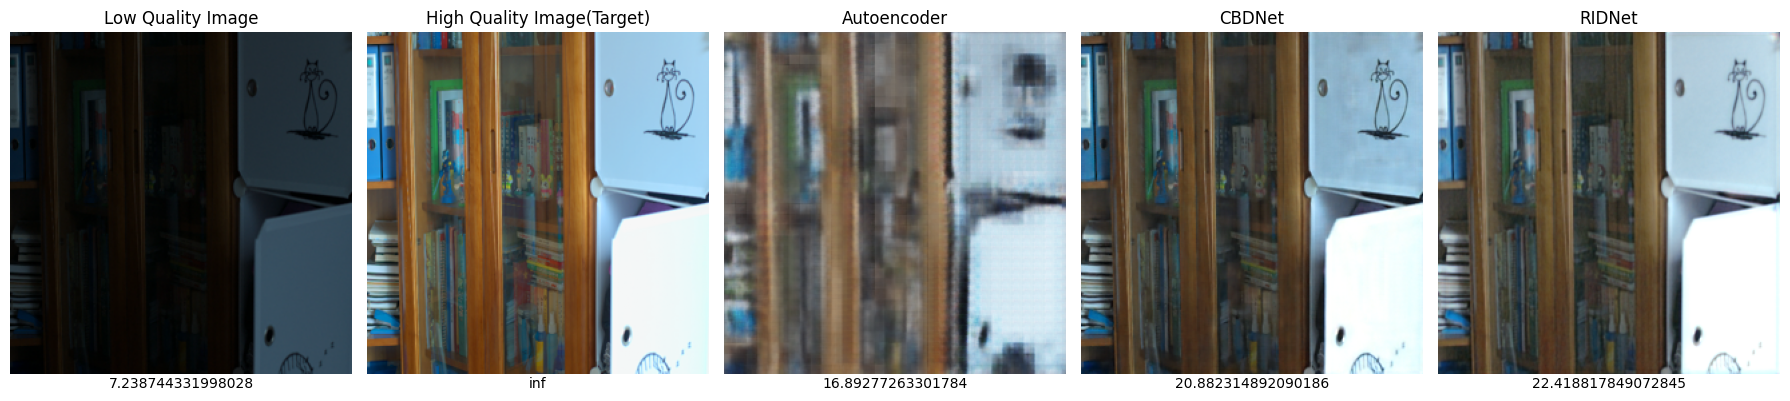

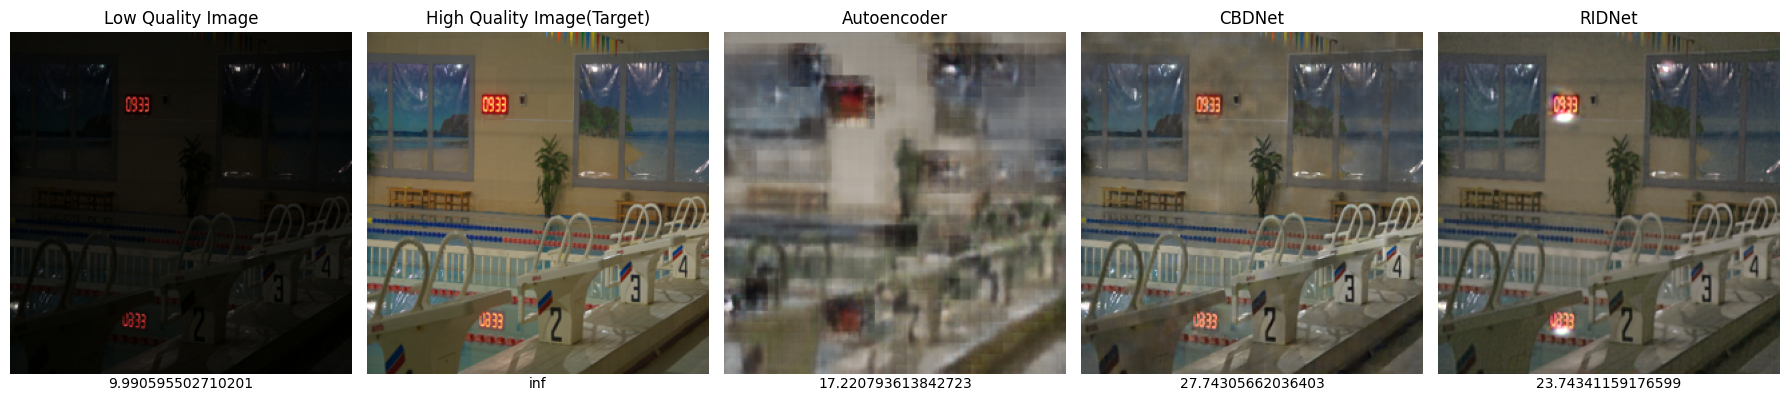

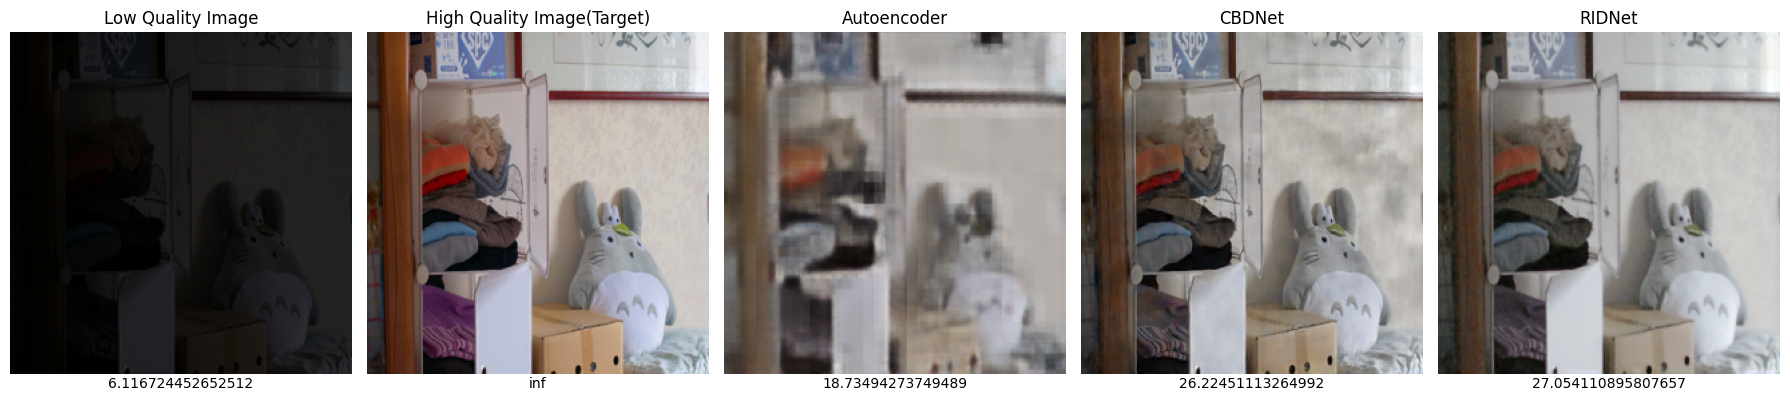

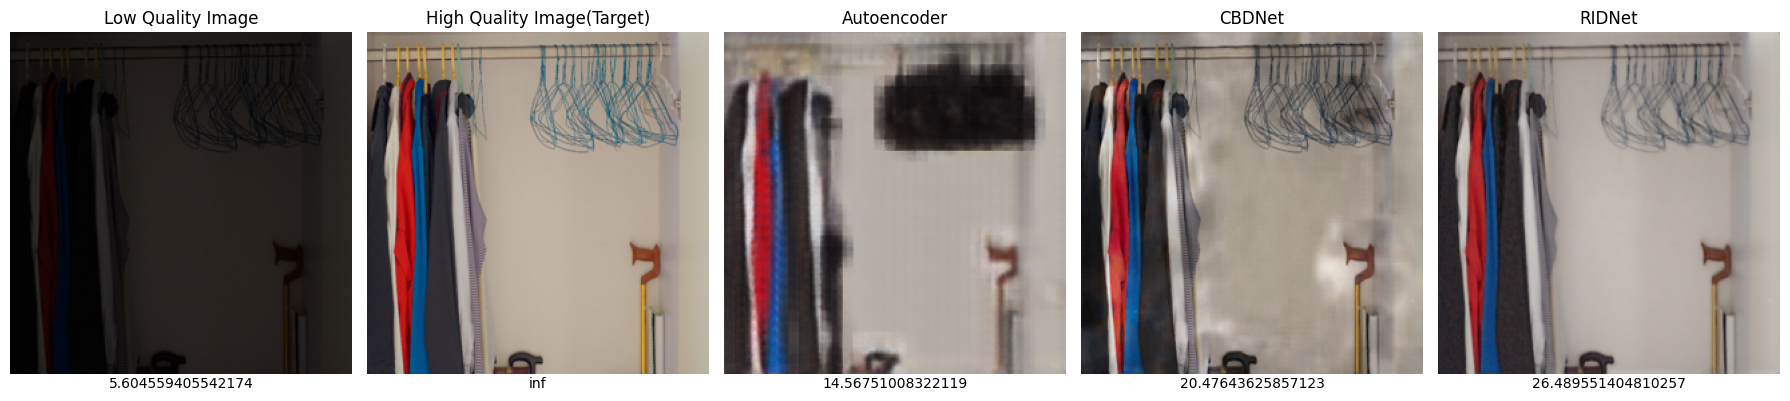

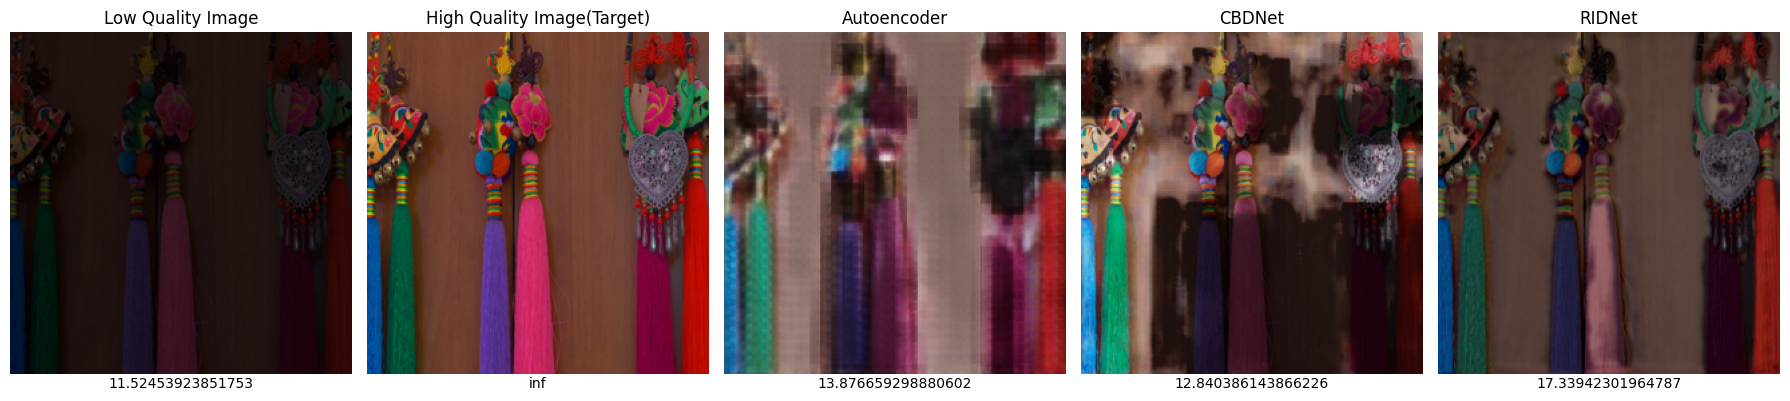

In [18]:
val_psnr_t_autoencoder, val_psnr_t_cbdnet, val_psnr_t_ridnet, val_ssim_t_autoencoder, val_ssim_t_cbdnet, val_ssim_t_ridnet = validation(autoencoder_model, cbdnet_model, ridnet_model)

In [19]:
val_psnr_t_autoencoder, val_psnr_t_cbdnet, val_psnr_t_ridnet, val_ssim_t_autoencoder, val_ssim_t_cbdnet, val_ssim_t_ridnet

(15.390751112406978,
 22.016408885359205,
 22.3789696824852,
 0.5944517314069168,
 0.7886678222592778,
 0.7459209432610435)

In [20]:
def compare(val_psnr_t_autoencoder, val_psnr_t_cbdnet, val_psnr_t_ridnet, val_ssim_t_autoencoder, val_ssim_t_cbdnet, val_ssim_t_ridnet):

    models = ["Autoencoder", "CBDNet", "RIDNet"]

    psnr_values = [val_psnr_t_autoencoder, val_psnr_t_cbdnet, val_psnr_t_ridnet]

    ssim_values = [val_ssim_t_autoencoder, val_ssim_t_cbdnet, val_ssim_t_ridnet]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

    ax1.bar(models, psnr_values, color=['blue', 'green', 'orange'])
    ax1.set_xlabel("Models")
    ax1.set_ylabel("PSNR")
    ax1.set_title("PSNR Comparison")
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    ax2.bar(models, ssim_values, color=['blue', 'green', 'orange'])
    ax2.set_xlabel("Models")
    ax2.set_ylabel("SSIM")
    ax2.set_title("SSIM Comparison")
    ax2.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

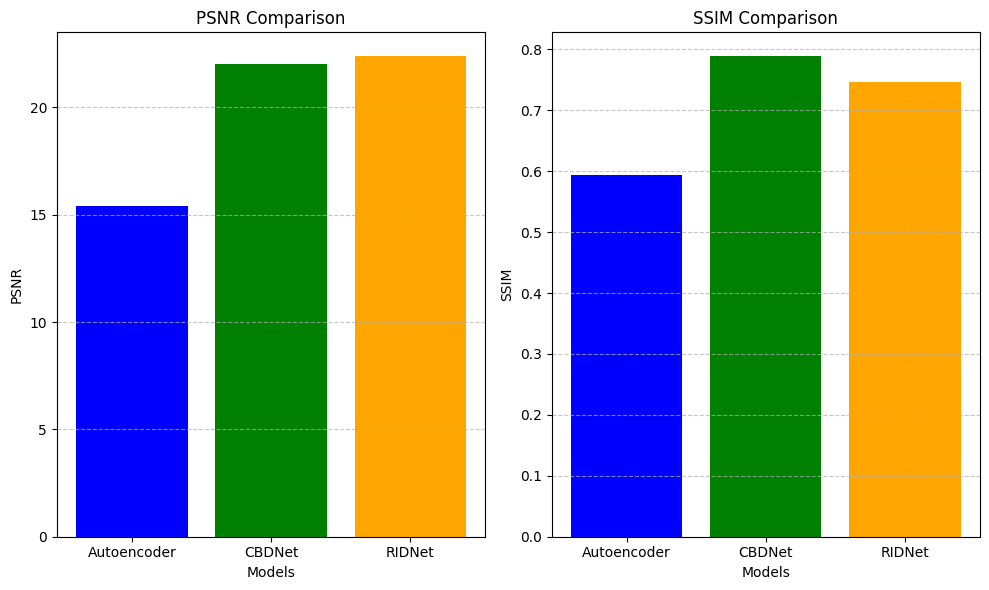

In [21]:
compare(val_psnr_t_autoencoder, val_psnr_t_cbdnet, val_psnr_t_ridnet, val_ssim_t_autoencoder, val_ssim_t_cbdnet, val_ssim_t_ridnet)